##Imports

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

##Database Connection

In [2]:
db = "/content/Chinook_Sqlite.sqlite"

In [3]:
conn = sqlite3.connect(db)
tables = pd.read_sql("""SELECT *
                        FROM sqlite_master
                        WHERE type='table';""", conn)
tables

,type,name,tbl_name,rootpage,sql
0,table,Album,Album,19,CREATE TABLE [Album]\n(\n [AlbumId] INTEGER...
1,table,Artist,Artist,281,CREATE TABLE [Artist]\n(\n [ArtistId] INTEG...
2,table,Customer,Customer,386,CREATE TABLE [Customer]\n(\n [CustomerId] I...
3,table,Employee,Employee,392,CREATE TABLE [Employee]\n(\n [EmployeeId] I...
4,table,Genre,Genre,395,CREATE TABLE [Genre]\n(\n [GenreId] INTEGER...
5,table,Invoice,Invoice,396,CREATE TABLE [Invoice]\n(\n [InvoiceId] INT...
6,table,InvoiceLine,InvoiceLine,399,CREATE TABLE [InvoiceLine]\n(\n [InvoiceLin...
7,table,MediaType,MediaType,402,CREATE TABLE [MediaType]\n(\n [MediaTypeId]...
8,table,Playlist,Playlist,404,CREATE TABLE [Playlist]\n(\n [PlaylistId] I...
9,table,PlaylistTrack,PlaylistTrack,405,CREATE TABLE [PlaylistTrack]\n(\n [Playlist...


##Data overview

In [4]:
albums = pd.read_sql("""SELECT *
                        FROM Album;""", conn)
albums.head(10)

,AlbumId,Title,ArtistId
0,1,For Those About To Rock We Salute You,1
1,2,Balls to the Wall,2
2,3,Restless and Wild,2
3,4,Let There Be Rock,1
4,5,Big Ones,3
5,6,Jagged Little Pill,4
6,7,Facelift,5
7,8,Warner 25 Anos,6
8,9,Plays Metallica By Four Cellos,7
9,10,Audioslave,8


In [5]:
artist = pd.read_sql("""SELECT *
                        FROM Artist
                        LEFT JOIN Album ON Album.ArtistId = Artist.ArtistId """,conn)
artist.head(10)

,ArtistId,Name,AlbumId,Title,ArtistId
0,1,AC/DC,1.0,For Those About To Rock We Salute You,1.0
1,1,AC/DC,4.0,Let There Be Rock,1.0
2,2,Accept,2.0,Balls to the Wall,2.0
3,2,Accept,3.0,Restless and Wild,2.0
4,3,Aerosmith,5.0,Big Ones,3.0
5,4,Alanis Morissette,6.0,Jagged Little Pill,4.0
6,5,Alice In Chains,7.0,Facelift,5.0
7,6,Antônio Carlos Jobim,8.0,Warner 25 Anos,6.0
8,6,Antônio Carlos Jobim,34.0,Chill: Brazil (Disc 2),6.0
9,7,Apocalyptica,9.0,Plays Metallica By Four Cellos,7.0


##Top-selling products (by quantity and by revenue)

In [6]:
# Top products by quantity sold
top_by_qty = pd.read_sql("""
SELECT T.TrackId,
T.Name AS track_name,
SUM(IL.Quantity) AS total_quantity
FROM InvoiceLine IL
JOIN Track T ON T.TrackId = IL.TrackId
GROUP BY T.TrackId, T.Name
ORDER BY total_quantity DESC
LIMIT 20;
""", conn)
top_by_qty.head(10)

,TrackId,track_name,total_quantity
0,2,Balls to the Wall,2
1,8,Inject The Venom,2
2,9,Snowballed,2
3,20,Overdose,2
4,32,Deuces Are Wild,2
5,48,Not The Doctor,2
6,66,Por Causa De Você,2
7,84,Welcome Home (Sanitarium),2
8,161,Snowblind,2
9,162,Cornucopia,2


In [7]:
# Top products by revenue
top_by_revenue = pd.read_sql("""
SELECT T.TrackId,
T.Name AS track_name,
SUM(IL.Quantity * IL.UnitPrice) AS total_revenue
FROM InvoiceLine IL
JOIN Track T ON T.TrackId = IL.TrackId
GROUP BY T.TrackId, T.Name
ORDER BY total_revenue DESC
LIMIT 20;
""", conn)
top_by_revenue.head(10)

,TrackId,track_name,total_revenue
0,2832,The Woman King,3.98
1,2850,The Fix,3.98
2,2868,Walkabout,3.98
3,3177,Hot Girl,3.98
4,3200,Gay Witch Hunt,3.98
5,3214,Phyllis's Wedding,3.98
6,3223,How to Stop an Exploding Man,3.98
7,3250,Pilot,3.98
8,2820,Occupation / Precipice,1.99
9,2821,"Exodus, Pt. 1",1.99


##Revenue per region (country)

In [9]:
revenue_by_country = pd.read_sql("""
SELECT C.Country,
COUNT(DISTINCT I.InvoiceId) AS invoices_count,
SUM(IL.Quantity * IL.UnitPrice) AS total_revenue
FROM Invoice I
JOIN Customer C ON C.CustomerId = I.CustomerId
JOIN InvoiceLine IL ON IL.InvoiceId = I.InvoiceId
GROUP BY C.Country
ORDER BY total_revenue DESC;
""", conn)


revenue_by_country.head(10)

,Country,invoices_count,total_revenue
0,USA,91,523.06
1,Canada,56,303.96
2,France,35,195.10
3,Brazil,35,190.10
4,Germany,28,156.48
5,United Kingdom,21,112.86
6,Czech Republic,14,90.24
7,Portugal,14,77.24
8,India,13,75.26
9,Chile,7,46.62


##Monthly performance (time-series of revenue)

<Axes: title={'center': 'Monthly Revenue'}, xlabel='year_month'>

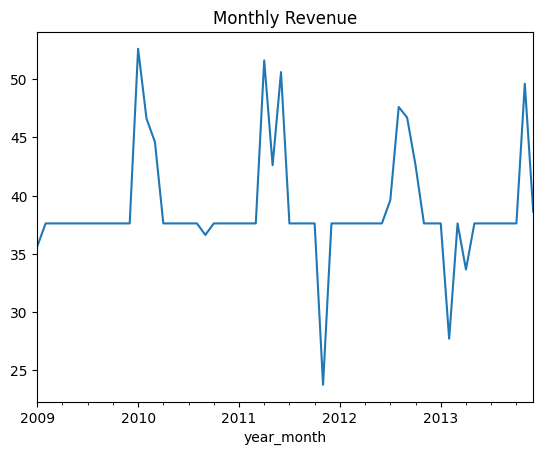

In [10]:
monthly_revenue = pd.read_sql("""
SELECT strftime('%Y-%m', I.InvoiceDate) AS year_month,
SUM(IL.Quantity * IL.UnitPrice) AS revenue
FROM Invoice I
JOIN InvoiceLine IL ON IL.InvoiceId = I.InvoiceId
GROUP BY year_month
ORDER BY year_month;
""", conn)


# Convert to datetime index and plot
monthly_revenue['year_month'] = pd.to_datetime(monthly_revenue['year_month'])
monthly_revenue = monthly_revenue.set_index('year_month')
monthly_revenue.plot(y='revenue', legend=False, title='Monthly Revenue')